Это задание связано с анализом конкретного датасета, в котором, надеюсь, понадобится
то, чему мы с вами до сих пор научились. Датасет давайте возьмём довольно релевантный
реальной жизни; он доступен по следующей ссылке:

https://ourworldindata.org/coronavirus-source-data

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression, Ridge

In [2]:
# Настройка параметров графиков
params = {'figure.figsize': (16, 10),
          'legend.fontsize': 14,
          'axes.labelsize': 20,
          'axes.titlesize': 26,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')

# Подготовка данных

Скачайте данные в формате csv, выберите из таблицы данные по России, начиная
с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве
целевой переменной возьмём число случаев заболевания (столбцы total_cases и
new_cases); для упрощения обработки можно заменить в столбце new_cases все
нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в
виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно
использовать в качестве тестового набора (и он даже будет увеличиваться по мере
выполнения задания).

In [3]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
open('owid-covid-data.csv', 'wb').write(requests.get(url).content)

47479300

Прочитаем датасет и проведем его предобработку

In [4]:
covid_df = pd.read_csv(r"owid-covid-data.csv")
covid_df.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


In [5]:
# Возьмем только нужные нам столбцы
columns = ["date", "location", "total_cases", "new_cases"]
covid_df = covid_df[columns]
# Отфильтруем по России
covid_df = covid_df[covid_df["location"] == "Russia"]
# Оставим только случаи после 3 марта
start_date = datetime(2020, 3, 3)
covid_df["date"] = pd.to_datetime(covid_df["date"], format="%Y-%m-%d")
covid_df = covid_df[covid_df["date"] >= start_date]

In [6]:
# для упрощения обработки заменим в столбце new_cases все нули на единицы
covid_df.loc[covid_df["new_cases"] == 0, "new_cases"] = 1
# Выделим номер дня с начала отсчета в отдельный столбец
covid_df["day"] = (covid_df["date"] - start_date).dt.days
covid_df.head()

,date,location,total_cases,new_cases,day
123955,2020-03-03,Russia,3.0,1.0,0
123956,2020-03-04,Russia,3.0,1.0,1
123957,2020-03-05,Russia,4.0,1.0,2
123958,2020-03-06,Russia,13.0,9.0,3
123959,2020-03-07,Russia,13.0,1.0,4


In [7]:
# Выделим тренировочный и тестовый наборы
covid_train = covid_df.iloc[:50]
covid_test = covid_df.iloc[50:]

# Первое приближение

Постройте графики целевых переменных. Вы увидите, что число заболевших
растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к
снаряду давайте это и используем.

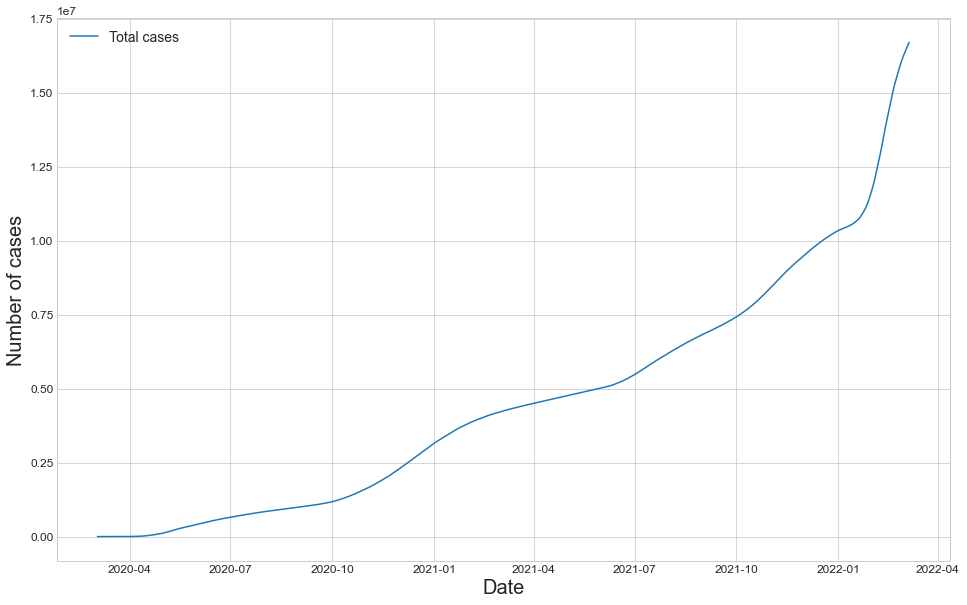

In [8]:
# plt.figure(figsize=figsize)
plt.plot(covid_df["date"], covid_df["total_cases"], label="Total cases")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Number of cases")
plt.legend()

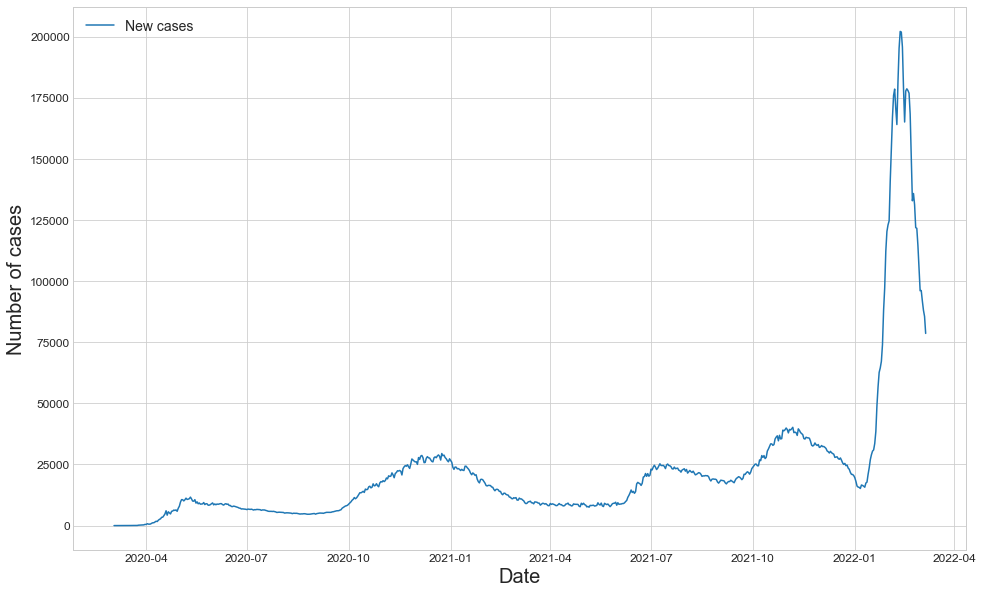

In [9]:
plt.plot(covid_df["date"], covid_df["new_cases"], label="New cases")
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Number of cases")
plt.legend()

## a

Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: _y ~ exp(линейная функция от x)_, где x — номер текущего дня.

Представим функцию числа заболевших в виде:

$$y \sim e^{kx + b}$$

Прологарифмируем обе чати выражения и получим:

$$log(y) \sim log(e^{kx + b}) = kx + b$$

Где x — номер текущего дня.

In [10]:
model = LinearRegression()
model.fit(covid_train["day"].values.reshape(-1, 1),
          np.log(covid_train["total_cases"]))

LinearRegression()

In [11]:
model_res = model.predict(covid_train["day"].values.reshape(-1, 1))

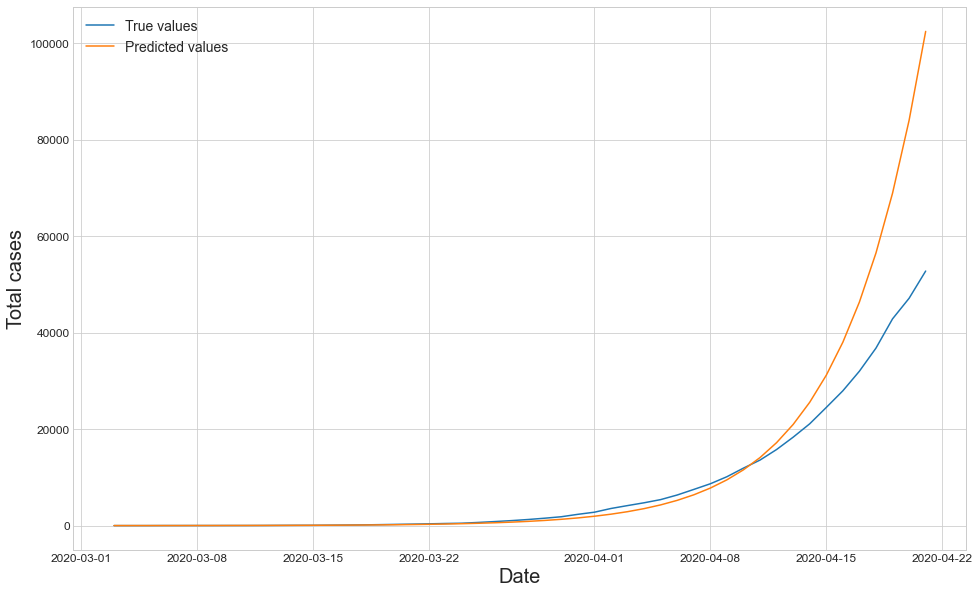

In [12]:
plt.plot(covid_train["date"], covid_train["total_cases"], label="True values")
plt.plot(covid_train["date"], np.exp(model_res), label="Predicted values")
plt.xlabel("Date")
plt.ylabel("Total cases")
plt.legend()

## b

Найдите апостериорное распределение параметров этой модели для
достаточно широкого априорного распределения. Требующееся для этого
значение дисперсии шума в данных оцените, исходя из вашей же
максимальной апостериорной модели (это фактически первый шаг
эмпирического Байеса)

Для оценки дисперсии возьмем следующую формулу:
$$\sigma^2 = \frac{1}{N} \sum_{n=1}^{N}(y_n - w^T \hat{y}(x_n))^2$$

In [13]:
sigma_noise = np.mean((np.log(covid_train["total_cases"]) - model_res) ** 2)
sigma_noise

0.12183046154391229

In [14]:
def bayesian_update(mu, sigma, x, y, sigma_noise):
    sigma_n = np.linalg.inv(np.linalg.inv(sigma) + (1 / (sigma_noise ** 2)) *
                            np.matmul(np.transpose(x), x) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) +
                     (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x), y))
    return mu_n, sigma_n

In [15]:
x = np.column_stack([np.ones(covid_train.shape[0]), covid_train["day"]])

mu, sigma = bayesian_update(np.zeros(2), 1000 * np.eye(2), x,
                            np.log(covid_train["total_cases"]).values, sigma_noise)

In [16]:
print(f"Mu:\n{mu}")
print(f"Sigma:\n{sigma}")

Mu:
[1.82073506 0.19829098]
Sigma:
[[ 1.15248767e-03 -3.49238688e-05]
 [-3.49238688e-05  1.42546446e-06]]


## c

Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя
из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к
1 июня? к 1 сентября? Постройте предсказательные распределения (можно
эмпирически, исходя из данных сэмплирования).

In [17]:
n = 1000
my_w = np.random.multivariate_normal(mu, sigma, n)

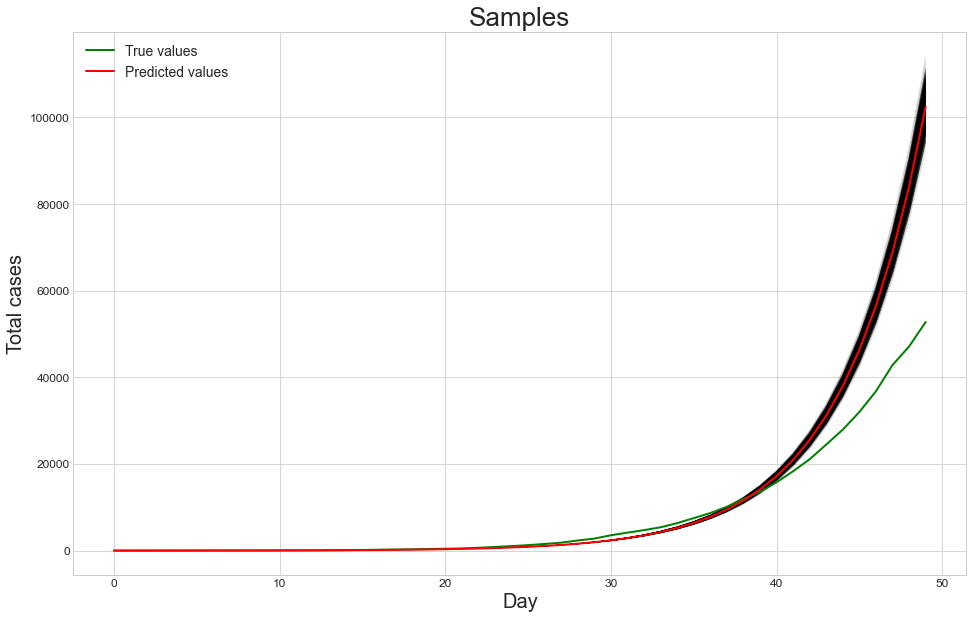

In [18]:
plt.title("Samples")
for i in range(n):
    plt.plot(covid_train["day"], np.exp(x.dot(my_w[i])),
             color="k", linewidth=.1)
plt.plot(covid_train["day"], covid_train["total_cases"],
         label="True values", color="g", linewidth=2)
plt.plot(covid_train["day"], np.exp(model_res),
         label="Predicted values", color="r", linewidth=2)
plt.xlabel("Day")
plt.ylabel("Total cases")
plt.legend();

In [19]:
may = (datetime(2020, 5, 1) - start_date).days
june = (datetime(2020, 6, 1) - start_date).days
sept = (datetime(2020, 9, 1) - start_date).days

In [20]:
x = pd.Series([may, june, sept])

x_matrix = np.column_stack([np.ones(len(x)), x])

prediction = np.exp(my_w.dot(x_matrix.T))

Text(0.5, 1.0, 'May 1 prediction distribution')

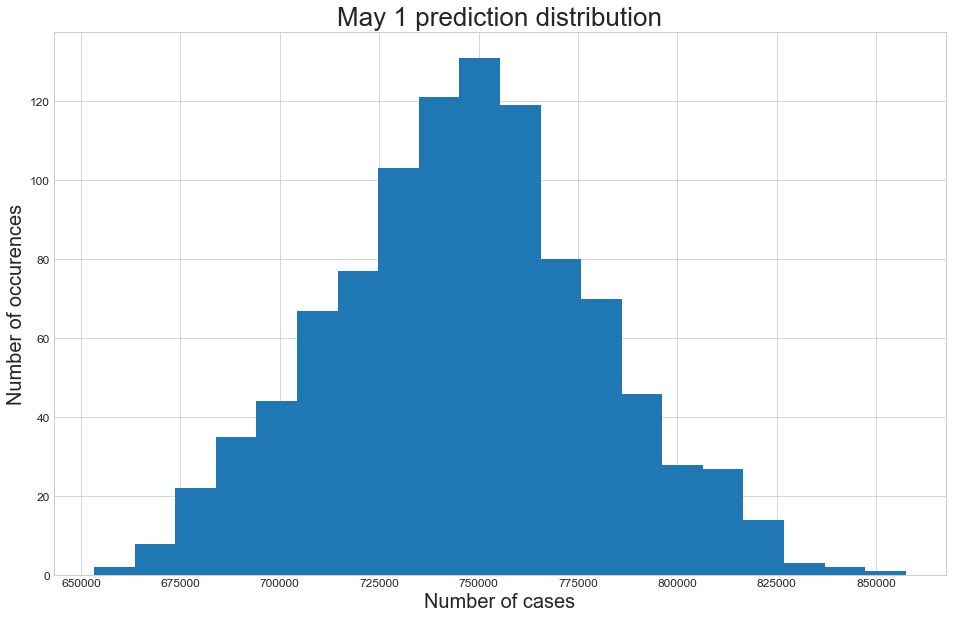

In [21]:
plt.hist(prediction[:, 0], bins=20)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("May 1 prediction distribution")

In [22]:
print("May 1 predictions")
print(f"Median:\t\t{round(np.quantile(prediction[:, 0], 0.5))}")
print(f"True value:\t{covid_test[covid_test['day'] == may]['total_cases'].iloc[0]}")

May 1 predictions
Median:		747351.0
True value:	114431.0


Text(0.5, 1.0, 'June 1 prediction distribution')

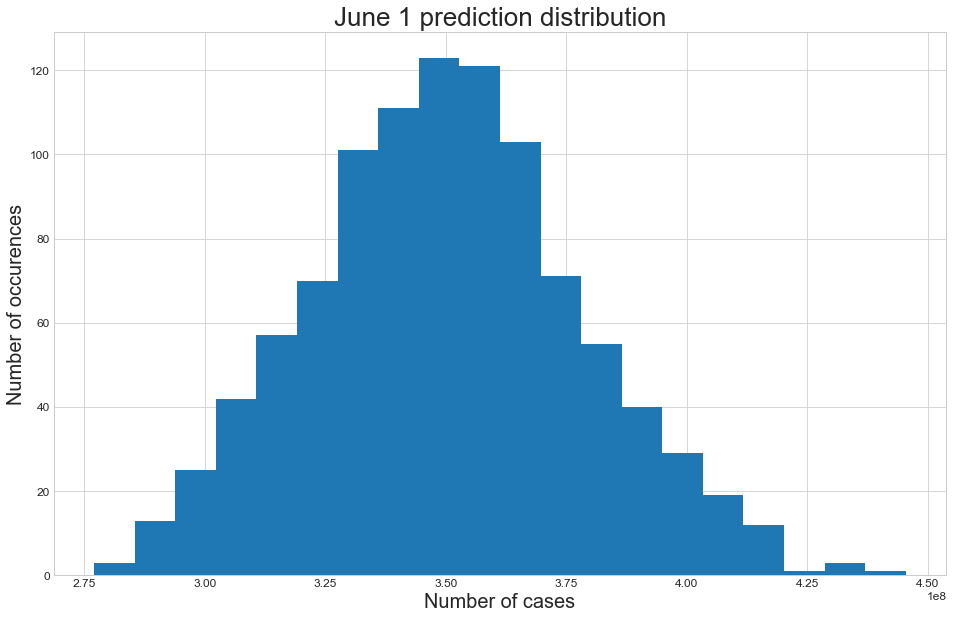

In [23]:
plt.hist(prediction[:, 1], bins=20)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("June 1 prediction distribution")

In [24]:
print("June 1 predictions")
print(f"Median:\t\t{round(np.quantile(prediction[:, 1], 0.5))}")
print(f"True value:\t{covid_test[covid_test['day'] == june]['total_cases'].iloc[0]}")

June 1 predictions
Median:		349730937.0
True value:	414328.0


Text(0.5, 1.0, 'September 1 prediction distribution')

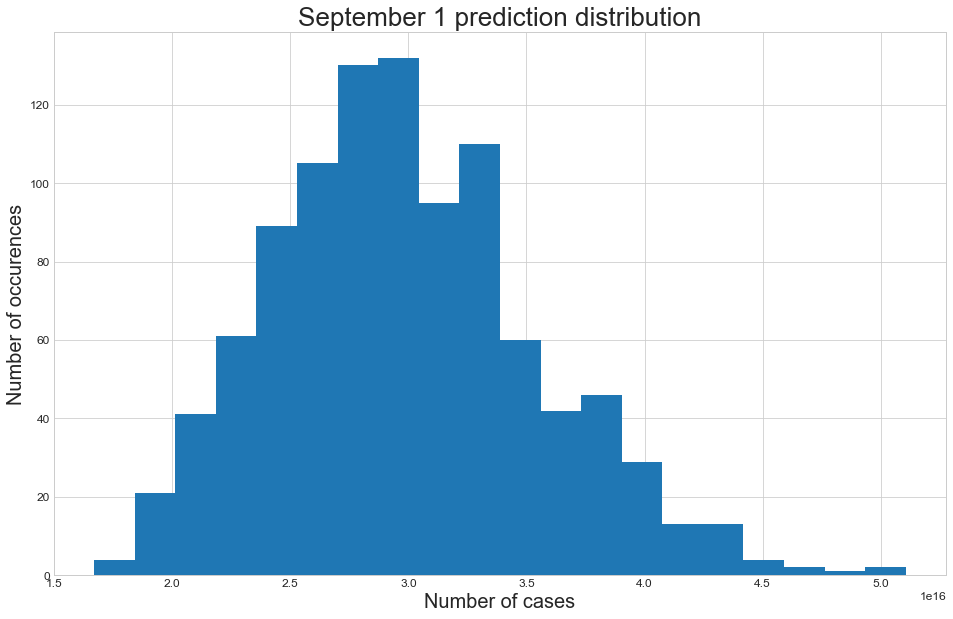

In [25]:
plt.hist(prediction[:, 2], bins=20)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("September 1 prediction distribution")

In [26]:
print("September 1 predictions")
print(f"Median:\t\t{round(np.quantile(prediction[:, 2], 0.5))}")
print(f"True value:\t{covid_test[covid_test['day'] == sept]['total_cases'].iloc[0]}")

September 1 predictions
Median:		2.941938330332348e+16
True value:	997072.0


# Сигмоида

Действительно, грустные предсказания - уже к июню все население России должно было по два раза переболеть.

Предсказания экспоненциальной модели наверняка получились грустными. Но это, конечно, чересчур пессимистично — экспоненциальный рост в природе никак не может продолжаться вечно. Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста неизбежно происходит насыщение. В качестве конкретной формы такой сигмоиды давайте возьмём форму функции распределения для гауссиана:

$$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^x \mathrm{e}^{-t^2/2}\,\mathrm{d}t$$

Естественно, в нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту), а в экспоненте под интегралом может быть произвольная квадратичная функция от _t_.

## a

Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии.

Выражение $-t^2/2$ в экпоненте можно заменить на обычную квадратичную функцию $ at^2 + bt + c$, чтобы уравнение сигмоиды принято вид:

$$ y(x) = \int_{-\infty}^{x}\mathrm{e}^{at^2 + bt + c}\mathrm{d}t$$

Интегрировать, очевидно, нужно в интервале от 0 до x (дни с начала пандемии), и если после взятия интеграла прологарифмировать выражение аналогично первому приближению, получим
$$ \mathrm{log}(y_i - y_{i - 1}) = ax^2 + bx + c$$

Таким образом, признаками для обучения модели будут номер дня и его квадрат, а в качестве целевой переменной — логарифм разности текущего и предыдущего значений целевой переменной (столбец new_cases).

## b

Обучите эти параметры на датасете случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели.


In [27]:
sigmoid_model = LinearRegression()

In [28]:
X = np.column_stack([covid_train["day"], covid_train["day"] ** 2])
y = np.log(covid_train["new_cases"].values)

In [29]:
sigmoid_model.fit(X, y)

LinearRegression()

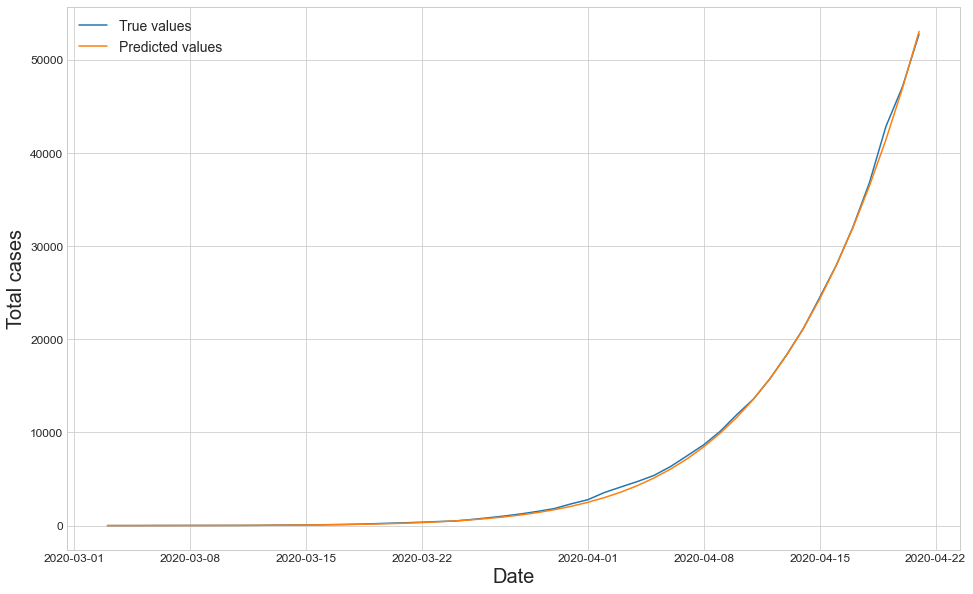

In [30]:
sigmoid_model_res = sigmoid_model.predict(X)

plt.plot(covid_train["date"], covid_train["total_cases"], label="True values")
plt.plot(covid_train["date"], np.exp(sigmoid_model_res).cumsum(), label="Predicted values")
plt.xlabel("Date")
plt.ylabel("Total cases")
plt.legend()

In [31]:
sigmoid_model_sigma_noise = np.mean((y - sigmoid_model_res) ** 2)
sigmoid_model_x = np.column_stack([np.ones_like(covid_train["day"]), X])


In [32]:
sigmoid_model_mu, sigmoid_model_sigma = bayesian_update(
    np.zeros(3),
    1000 * np.eye(3),
    sigmoid_model_x,
    y,
    sigmoid_model_sigma_noise
)

In [33]:
print(f"Mu:\n{sigmoid_model_mu}")
print(f"Sigma:\n{sigmoid_model_sigma}")

Mu:
[-0.39658641  0.2756225  -0.00182979]
Sigma:
[[ 9.52394107e-03 -7.69480531e-04  1.29542176e-05]
 [-7.69480531e-04  8.48437326e-05 -1.61928267e-06]
 [ 1.29542176e-05 -1.61928267e-06  3.30466208e-08]]


## c

Посэмплируйте много разных сигмоид из апостериорного распределения,
постройте графики. Сколько, исходя из этих сэмплов, будет всего случаев
коронавируса в России? Постройте эмпирическое предсказательное
распределение, нарисуйте графики. Каков ваш прогноз числа случаев
коронавируса в пессимистичном сценарии (90-й процентиль в выборке
числа случаев)? В оптимистичном сценарии (10-й процентиль)?

In [34]:
n = 1000
sigmoid_model_my_w = np.random.multivariate_normal(sigmoid_model_mu, sigmoid_model_sigma, n)

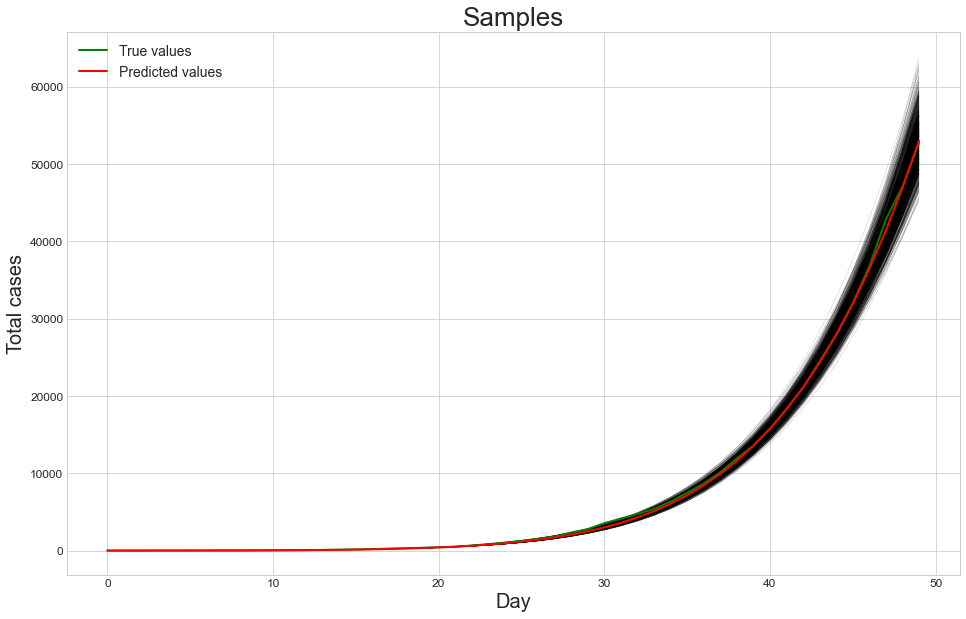

In [35]:
plt.title("Samples")
for i in range(n):
    plt.plot(covid_train["day"], np.exp(sigmoid_model_x.dot(sigmoid_model_my_w[i])).cumsum(),
             color="k", linewidth=.1)
plt.plot(covid_train["day"], covid_train["total_cases"],
         label="True values", color="g", linewidth=2)
plt.plot(covid_train["day"], np.exp(sigmoid_model_res).cumsum(),
         label="Predicted values", color="r", linewidth=2)
plt.xlabel("Day")
plt.ylabel("Total cases")
plt.legend()

In [36]:
days = np.arange(sept + 1)
days_matrix = np.column_stack([np.ones(days.shape[0]), days, days ** 2])
sigmoid_model_prediction = np.exp(sigmoid_model_my_w.dot(days_matrix.T)).cumsum(1)

Text(0.5, 1.0, 'May 1 prediction distribution')

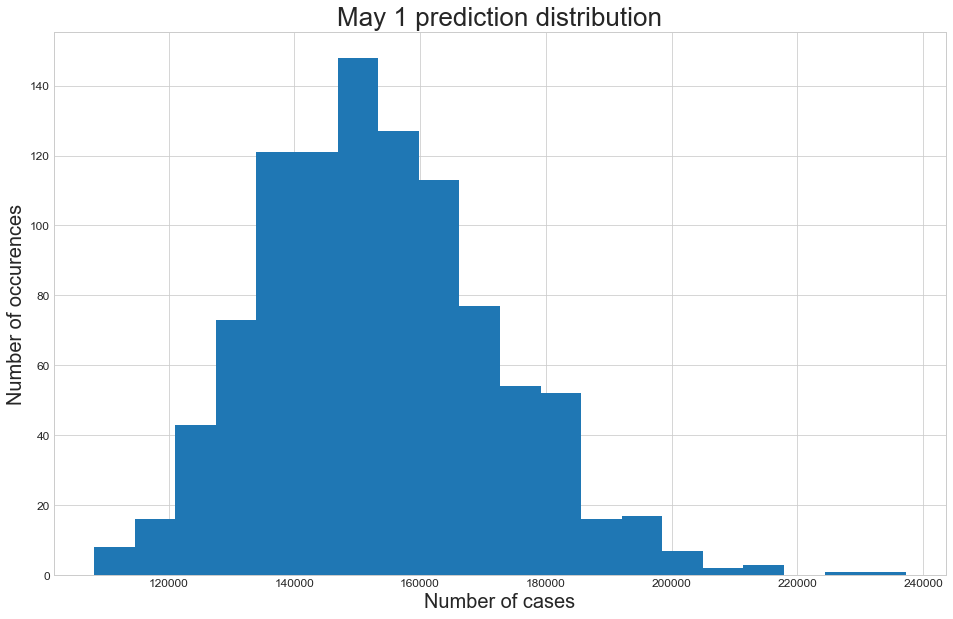

In [37]:
plt.hist(sigmoid_model_prediction[:, may], bins=20)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("May 1 prediction distribution")

In [38]:
print("May 1 predictions")
print(f"Median:\t\t{round(np.quantile(sigmoid_model_prediction[:, may], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(sigmoid_model_prediction[:, may], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(sigmoid_model_prediction[:, may], 0.9))}")
print(f"True value:\t{covid_test[covid_test['day'] == may]['total_cases'].iloc[0]}")

May 1 predictions
Median:		151838.0
10-quantile:	130283.0
90-quantile:	178772.0
True value:	114431.0


Text(0.5, 1.0, 'June 1 prediction distribution')

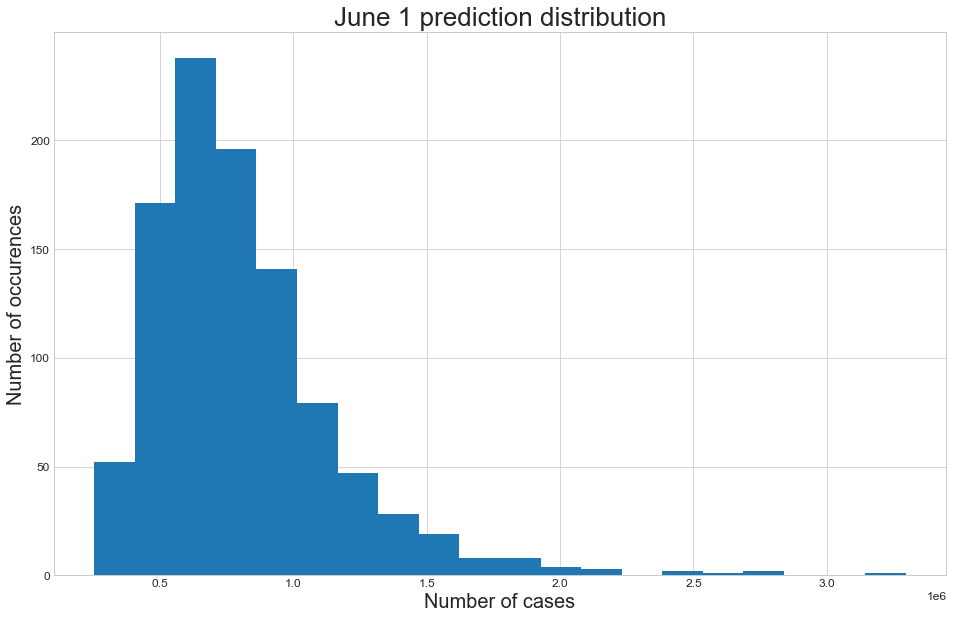

In [39]:
plt.hist(sigmoid_model_prediction[:, june], bins=20)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("June 1 prediction distribution")

In [40]:
print("June 1 predictions")
print(f"Median:\t\t{round(np.quantile(sigmoid_model_prediction[:, june], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(sigmoid_model_prediction[:, june], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(sigmoid_model_prediction[:, june], 0.9))}")
print(f"True value:\t{covid_test[covid_test['day'] == june]['total_cases'].iloc[0]}")

June 1 predictions
Median:		742729.0
10-quantile:	466243.0
90-quantile:	1228087.0
True value:	414328.0


Text(0.5, 1.0, 'September 1 prediction distribution')

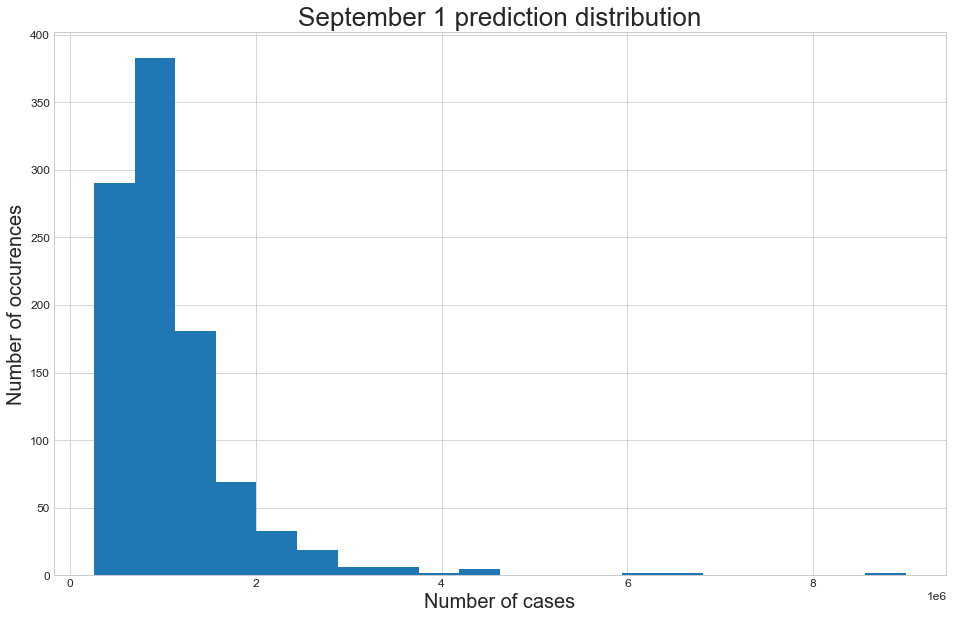

In [41]:
plt.hist(sigmoid_model_prediction[:, sept], bins=20)
plt.xlabel("Number of cases")
plt.ylabel("Number of occurences")
plt.title("September 1 prediction distribution")

In [42]:
print("September 1 predictions")
print(f"Median:\t\t{round(np.quantile(sigmoid_model_prediction[:, sept], 0.5))}")
print(f"10-quantile:\t{round(np.quantile(sigmoid_model_prediction[:, sept], 0.1))}")
print(f"90-quantile:\t{round(np.quantile(sigmoid_model_prediction[:, sept], 0.9))}")
print(f"True value:\t{covid_test[covid_test['day'] == sept]['total_cases'].iloc[0]}")

September 1 predictions
Median:		901326.0
10-quantile:	513155.0
90-quantile:	1805148.0
True value:	997072.0


Заметно, что при таком моделировании результаты лучше соотносятся с реальностью, что лишний раз доказывает, насколько важно, чтобы модель учитывала "физику процесса". Также есть интересная тенденция, что чем больше дней прошло, тем ближе реальное значение к пессимистичному сценарию моделирования - если на 1 мая реальное значение было вне 10-го процентиля, то на уже первого сентября оно практически сравнялось с медианным значением всех прогнозов. Если продлить прогноз до декабря, то получим реальное значение в районе 95го процентиля прогноза, что говорит о том, что наверняка можно подобрать кривую, которая будет еще лучше предсказывать число заболевших на долгой дистанции.
